<h1> The Big Question </h1>

<h1>Read in data from database </h1>



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

In [2]:
#Connects to database 
connection = sqlite3.connect('database.sqlite') 

In [3]:
#Creates dataframes from SQL tables 
countries = pd.read_sql_query("SELECT * from Country", connection)
matches = pd.read_sql_query("SELECT * from Match", connection)
leagues = pd.read_sql_query("SELECT * from League", connection)
teams = pd.read_sql_query("SELECT * from Team", connection)



<H1>Basic Analysis and visualtion</H1>

In [4]:
#Get result of each match
def get_result(match):
    
    home = match.home_team_goal
    away = match.away_team_goal
    result = ''
    if home == away:
        result = 'D'
    elif home>away:
        result = 'H'
    else:
        result = 'A'
    return result 
    

In [5]:
#Creates results column in DF 
matches['result'] =matches.apply(get_result, axis = 1)


In [6]:
def get_best_odds():
    #Gets the best odds offered for each game for home away and draw results and creates columns 
    matches['best_home']= matches.apply(lambda x: max(x['B365H'],x['BWH'],x['IWH'],x['LBH'],x['PSH'],x['WHH'],x['SJH'],x['VCH'],x['GBH'],x['BSH']),axis = 1)
    matches['best_draw']= matches.apply(lambda x: max(x['B365D'],x['BWD'],x['IWD'],x['LBD'],x['PSD'],x['WHD'],x['SJD'],x['VCD'],x['GBD'],x['BSD']),axis = 1)
    matches['best_away']= matches.apply(lambda x: max(x['B365A'],x['BWA'],x['IWA'],x['LBA'],x['PSA'],x['WHA'],x['SJA'],x['VCA'],x['GBA'],x['BSA']),axis = 1)

In [7]:
def to_datetime():
    #Converts the date to datetime 
    import datetime
    #Switch the date column to datetime object 
    matches['date'] = pd.to_datetime(matches['date'])

In [8]:
get_best_odds()
to_datetime()


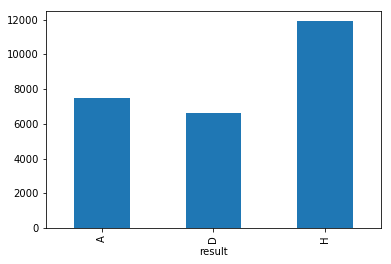

In [9]:
#Shows how many wins per home win and draw 
%matplotlib inline
import matplotlib.pyplot as plt
result = matches.groupby('result').size()
result.plot(kind = 'bar')

In [10]:
#Results by league 
league_results = matches.groupby(['result','league_id'])

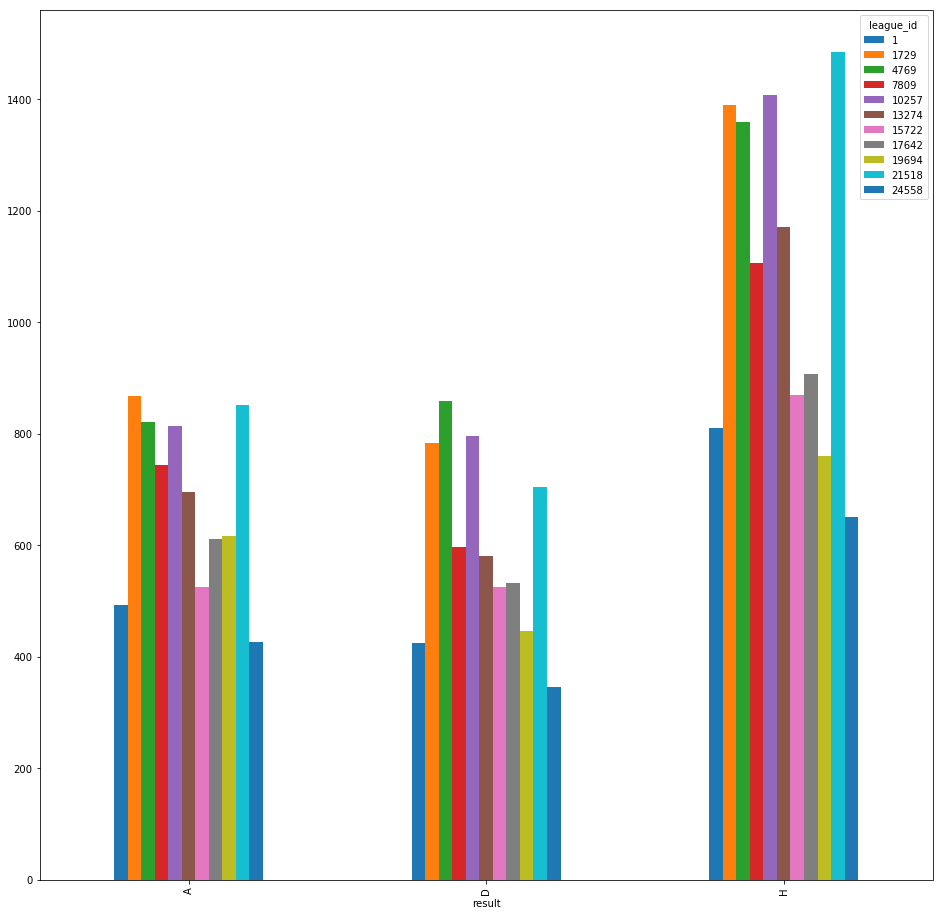

In [11]:
league_results.size().unstack().plot(kind='bar',figsize=(16,16))

In [12]:
#always betting the best odds for the home team 1 dollar per game 
matches['best_home_payout'] = matches['best_home']
matches['best_home_outcome'] = 'H'
matches.loc[~(matches.best_home_outcome==matches.result),'best_home_payout']=0
total_return_home = 100*(matches['best_home_payout'].sum()-matches['best_home_payout'].notnull().count())/matches['best_home_payout'].notnull().count()
total_return_home

-13.840313329997127

In [13]:
#always betting the best odds for the away team 1 dollar per game 
matches['best_away_payout'] = matches['best_away']
matches['best_away_outcome'] = 'A'
matches.loc[~(matches.best_away_outcome==matches.result),'best_away_payout']=0
total_return_away = 100*(matches['best_away_payout'].sum()-matches['best_away_payout'].notnull().count())/matches['best_away_payout'].notnull().count()
total_return_away

-16.870018091535123

In [14]:
#always betting the best odds for the draw 1 dollar per game 
matches['best_draw_payout'] = matches['best_draw']
matches['best_draw_outcome'] = 'D'
matches.loc[~(matches.best_draw_outcome==matches.result),'best_draw_payout']=0
total_return_draw = 100*(matches['best_draw_payout'].sum()-matches['best_draw_payout'].notnull().count())/matches['best_draw_payout'].notnull().count()
total_return_draw

-17.29862581315599

<h1> Data Preprocessing for ML </h1>

In [15]:
#Selects only matches from major leagues-England, Spain Italy, France, germany 
good_leagues = [1729,4769,7809,10257,21518]
good_matches = matches.loc[matches.league_id.isin(good_leagues)]

In [16]:
#Converts dates to datetime 
def good_matches_to_date ():
    good_matches.loc['date'] = pd.to_datetime(good_matches['date'])
    
good_matches_to_date()

/Users/RyanMiller/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
def get_all_bookies():
    #Gets all bookies list 
    all_bookies = ['B365','BW','IW','LB','PS','WH','SJ','VC','GB','BS']
    return all_bookies

In [18]:
def get_good_bookies():
    #Select bookies that offer odds on all but 100 of matches 
    bookies = get_all_bookies()
    good_bookies = []
    for bookie in bookies:
        #Gets home bookies 
        name = bookie+'H'
        #Counts matches bookie does not offer home odds 
        null = (good_matches[pd.isnull(good_matches[name]) == True])
        num_null = null['id'].count()
        #if less than 100 throwout 
        if num_null < 100:
            good_bookies.append(bookie)
    return good_bookies

get_good_bookies()

['B365', 'BW', 'IW', 'LB', 'WH', 'VC']

In [19]:
def get_past_matches(matches,team_id,date,n=10):
    #Gets the n past matches for a given team and given date
    
    #gets all matches that team has played either home or away 
    team_matches =  matches[(matches['home_team_api_id'] == team_id) | (matches['away_team_api_id'] == team_id)]
    #Converts date to datetime
    date = pd.to_datetime(date)
    #Gets last n matches from all matches played 
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:n,:]
    return last_matches

In [20]:
def get_past_matches_against_team(matches, date, team1, team2, n=5 ):
    #Gets last n matches between two teams 
    #Gets matches when one team is home and when the other is home 
    team1_home = matches[(matches['home_team_api_id'] == team1) & (matches['away_team_api_id'] == team2)]    
    team2_home = matches[(matches['home_team_api_id'] == team2) & (matches['away_team_api_id'] == team1)]  
    #Combine the two sets of matches 
    total_matches = pd.concat([team1_home, team2_home])
    date = pd.to_datetime(date)
    #Get last n of combines or if not n how many there are 
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:n,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
    return last_matches
    

In [21]:
def goals(matches, team):
    #gets number of goals in a set of matches for one team 
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    #Return total goals
    return total_goals

In [22]:
def goals_against(matches, team):
    #gets number of goals given up in a set of matches for one team 
    
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    return total_goals

In [23]:
def get_wins(matches, team):
#Get number of wins for a team in a set of games 
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    return total_wins      
    

In [24]:
def get_odds(match,bookies):
#For a given match get all of the odds offered by a list of bookies given 
    odds = {}
    #For each bookie 
    for bookie in bookies:
        odds[bookie] = {}
        #Get name of home,away and draw bookie 
        bookie_h = bookie+'H'
        bookie_a = bookie+'A'
        bookie_d = bookie+'D'  
        #add odds to dictionary 
        odds[bookie]['home'] = match[bookie_h]
        odds[bookie]['away'] = match[bookie_a]
        odds[bookie]['draw'] = match[bookie_d]
    
    return odds



In [25]:
def get_probabilities(odds):
    #Given a dictionary of odds convert to a series of probabilities implied by the odds(normalized)
    probs = pd.Series()
    #For each bookie in the odds dictionary 
    for key in odds:
        #Get home away and draw odds 
        home_prob  = 1/odds[key]['home']
        away_prob  = 1/odds[key]['away']
        draw_prob = 1/odds[key]['draw']
        #add for total and then normalize  enter into series 
        total_prob = home_prob+away_prob+draw_prob
        probs.loc[key+'H'] = home_prob / total_prob
        probs.loc[key+'D'] = draw_prob / total_prob
        probs.loc[key+'A'] = away_prob / total_prob
    return probs


In [26]:
def get_all_probs(match,bookies):
    #given a match and a set of bookies return probs using functions above and add match id for merging 
    odds = get_odds(match,bookies)
    probs = get_probabilities(odds)
    probs.loc['match_api_id'] = match.match_api_id
    return probs

In [27]:
def get_result_for_merge(match):
    #Gets the result of a match 
    result = pd.Series()
    home = match.home_team_goal
    away = match.away_team_goal
    match_id = match.match_api_id
    result.loc['match_api_id'] = match_id
    if home == away:
        result.loc['result'] = 'D'
    elif home>away:
        result.loc['result'] = 'H'
    else:
        result.loc['result'] = 'A'
    return result 

In [28]:
def get_match_data(match,matches,n =10):
    #Gets all data on past matches for both teams for a given match 
    
    date = pd.to_datetime(match.date)
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
    #Get last n matches of home and away team
    matches_home_team = get_past_matches(matches,home_team,date,n)
    matches_away_team = get_past_matches(matches, away_team,date,n)
    
    
    #Get last n matches of both teams against each other
    last_matches_against = get_past_matches_against_team(matches, date, home_team, away_team)
    
    
    
    #get goals homea and away team scored in last n matches they played 
    home_goals = goals(matches_home_team, home_team)
    away_goals = goals(matches_away_team, away_team)

    #get goals homea and away team scored in last n matches they played against each other 
    home_goals_against = goals_against(matches_home_team, home_team)
    away_goals_against = goals_against(matches_away_team, away_team)

    #Create a series with the information from above 
    data = pd.Series()
    data.loc[ 'match_api_id'] = match.match_api_id
    data.loc[ 'league_id'] = match.league_id
    data.loc['home_team_goals_difference'] = home_goals - home_goals_against
    data.loc['away_team_goals_difference'] = away_goals - away_goals_against
    data.loc['games_won_home_team'] = get_wins(matches_home_team, home_team) 
    data.loc['games_won_away_team'] = get_wins(matches_away_team, away_team)
    data.loc['games_against_won_home'] = get_wins(last_matches_against, home_team)
    data.loc['games_against_won_away'] = get_wins(last_matches_against, away_team)
    
    return data
    
   
    

In [29]:
def get_all_matches_data(matches,n =10,players = True ,stats='',bookies = get_good_bookies()):
    #Get all data for learning for a set of matches with option of player stats -function below- and bookies used 
    
    #calls match_data function for all matches given 
    match_stats = matches.apply(lambda x: get_match_data(x, matches), axis = 1)
    
   #gets names of columns of bookies probs 
    bookie_columns = []
    bookies = get_good_bookies()
    for bookie in bookies:
        home = bookie+'H'
        bookie_columns.append(home)
        away = bookie+'A'
        bookie_columns.append(away)
        draw = bookie+'D'
        bookie_columns.append(draw)
     
    
    #gets dataframe of odds for each bookie from the datagiven 
    odds = pd.DataFrame()
    for i in bookie_columns:
        odds[i] = matches[i]
    
    #takes odds and bookies and converts to probabilities
    probs = matches.apply(lambda x: get_all_probs(x,bookies),axis = 1)
    #Get result of each match 
    results = matches.apply(get_result_for_merge,axis = 1)
    
    #if players data asked for cal functoin and merge with match stats 
    if players == True:
        match_ratings = matches.apply(lambda x: get_match_ratings(x,stats),axis = 1)
        match_stats = pd.merge(match_stats, match_ratings, on = 'match_api_id', how = 'left')

    #merge stats with probs and results 
    match_stats = pd.merge(match_stats, probs, on = 'match_api_id', how = 'left')
    match_stats = pd.merge(match_stats,results, on = 'match_api_id',how = 'left')
    
    


    
    #return the odds and the DF matchstats 
    return odds,match_stats




In [30]:
#calls function above gettin a data set and the odds for that data set 
odds,simple_match_data =get_all_matches_data(good_matches,players = False) 

<h1>Machine learning using Random Forest classifier </h1>

In [31]:
def random_forest_classifier(data,gridsearch= True):
    #Creates classifier and outputs the predictions for the test and the model
    import numpy as np 
    
    #Drop match id and all rows that have a null value 
    data = data.drop('match_api_id', axis = 1)
    data = data.dropna()
    from sklearn.model_selection import train_test_split
    #Split data into the train and test with y being the result 
    result = data.loc[:,'result']
    features = data.drop('result', axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(features, result, test_size = 0.2)
    
    from sklearn.ensemble import RandomForestClassifier
    #Fit random forest with train data and print the score on test data
    model = RandomForestClassifier()
    model.fit(x_train,np.ravel(y_train))
    score = model.score(x_test,y_test)
    print("The score of the model is  ",score)

    


    #print the most important features of the data 
    import matplotlib.pyplot as plt
    %matplotlib inline
    feature_names = [key for key in data]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(12,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)),feature_names)
    plt.xlabel('Relative Importance')
    
    
    
    #If gridsearch then apply gridsearch on model 
    if gridsearch == True:
        from sklearn.model_selection import GridSearchCV
        parameters = {
         'n_estimators':(10,15,20,30), 
         'max_depth':(4,5,6,8,10,15),
         'min_samples_split': (2, 4, 8),
         'min_samples_leaf': (4,8,12,16)
    }
        
        #run gridsearch and get best score and best params 
        model = GridSearchCV(RandomForestClassifier(),parameters)
        model.fit(x_train, np.ravel(y_train))
        best_score = model.best_score_ 
        best_params = model.best_params_
        print("The best score from the GridSearch Randomforest is ",best_score)
        print("the best parameters from the gridsearch are: ",best_params)

        #new RF with gridsearch params
        b_model = RandomForestClassifier(max_depth=best_params['max_depth'],min_samples_leaf=best_params['min_samples_leaf'],min_samples_split=best_params['min_samples_split'],n_estimators=best_params['n_estimators'])
        b_model.fit(x_train,np.ravel(y_train))
        
        #print score 
        b_model_score = b_model.score(x_test,y_test)
        print("The gridsearch optimized model score is ", b_model_score)
    
        y_pred_b = b_model.predict(x_test)
        


        
        #predict probabilities of H,A,D for each match
        y_pred_probs = b_model.predict_proba(x_test)
    
    
    else: 
        #predict probabilities of H,A,D for each match
        y_pred_probs = model.predict_proba(x_test)



    y_pred_probs_no_grid =model.predict_proba(x_test)


    
    
    #Create dataframe for probabilities 
    probs = pd.DataFrame(y_pred_probs,columns = ["A","D","H"])







    #Get all column names for all bookies given Ex. B365 + H is home odds for B365 
    bookie_columns = []
    bookies = get_good_bookies()
    for bookie in bookies:
        home = bookie+'H'
        bookie_columns.append(home)
        away = bookie+'A'
        bookie_columns.append(away)
        draw = bookie+'D'
        bookie_columns.append(draw)
    
    
    #create dataframe with odds for each test from bookies given 
    bookie_probs = pd.DataFrame()
    for i in bookie_columns:
        bookie_probs[i] = x_test[i]
    bookie_probs.reset_index(inplace = True, drop = True)
    #create dataframe of results from the ytest 
    result = pd.DataFrame()
    result['result'] = y_test
    result.reset_index(inplace = True, drop = True)
    
    #join the three dataframes and return 
    probs = probs.join(bookie_probs)
    probs = probs.join(result)

    from sklearn.metrics import log_loss
    #Calculates log_loss 
    log_loss_no_grid = log_loss(y_test,y_pred_probs_no_grid)
    log_loss_grid = log_loss(y_test,y_pred_probs)
    print("The log loss for the no grid model is: ",log_loss_no_grid)
    print("The log loss for the grid search model is: ",log_loss_grid)
    

    return(b_model,probs)
    

The score of the model is   0.481213374698
The best score from the GridSearch Randomforest is  0.527753835546
the best parameters from the gridsearch are:  {'max_depth': 4, 'n_estimators': 30, 'min_samples_leaf': 16, 'min_samples_split': 2}
The gridsearch optimized model score is  0.540847983454
The log loss for the no grid model is:  0.969121450798
The log loss for the grid search model is:  0.970675968827


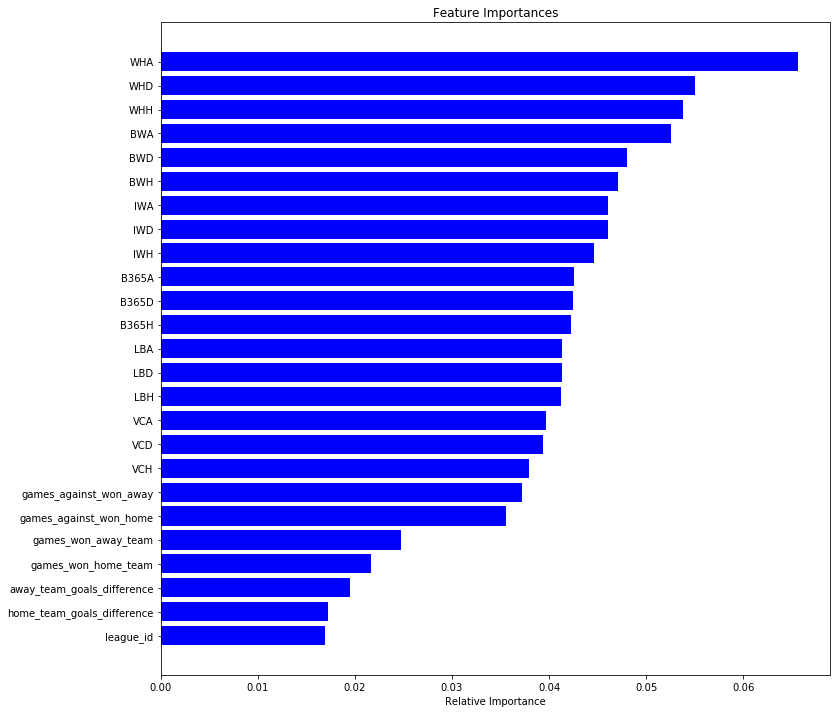

In [32]:
mdl,probz =  random_forest_classifier(simple_match_data)

<h1>When to Bet and Performance </h1>

In [33]:
def bet_decider(x):
    #decides what or any bet to make-bets the biggest difference in probability between model and bookies 
    bookies = get_good_bookies()
    home_odds = []
    away_odds = []
    draw_odds = []
    #gets list of bookies names for home away and draw 
    for bookie in bookies:
        home = bookie+'H'
        home_odds.append(home)
        away = bookie+'A'
        away_odds.append(away)
        draw = bookie+'D'
        draw_odds.append(draw)
        

    #gets best home odds-this is equivalent to the worst probability thus min 
    x['best_home'] = x.apply(lambda x: min(x[i] for i in home_odds),axis = 1)
    x['best_away'] = x.apply(lambda x: min(x[i] for i in away_odds),axis = 1)
    x['best_draw'] = x.apply(lambda x: min(x[i] for i in draw_odds),axis = 1)
    
    
    #The difference between the probabilities predicted by the model and the 
    x['home_difference'] = x['H']-x['best_home'] 
    x['away_difference'] = x['A']-x['best_away']
    x['draw_difference'] = x['D']-x['best_draw'] 
    #only placing one bet so pick the maximum absolute difference 
    x['max_difference'] = x.apply(lambda x: max(x['home_difference'],x['away_difference'],x['draw_difference']),axis = 1)
    
    
    def get_bet(row):
        #if none of probs are better than bookie implied then no bet 
        if row['max_difference']<0:
            return 'no_bet'
        
        
        #if home then bet home etc. 
        elif row['max_difference'] == row['home_difference']:
            return 'H'
        elif row['max_difference'] == row['away_difference']:
            return 'A'
        else:
            return 'D'
    

    #get bet for each match     
    x['bet'] = x.apply(get_bet,axis = 1)
    
    #if no bet then eliminate 
    x = x[x['bet']!='no_bet']
    
    #convert prob from bookies to odds 
    def get_odds_from_prob(row):
        
        bet = row['bet']
        prob = .00001
        #get prob 
        if bet == 'A':
            prob = row.best_away
        elif bet == 'H':
            prob = row.best_home
        else: 
            prob= row.best_draw
        #Return inverse as odds-Note this is normalized so this does not include implied fees or actual fees 
        odds = 1/prob
        return odds 
    x['bet_odds'] = x.apply(get_odds_from_prob,axis=1)
            
    
    return x 

In [34]:
rere = bet_decider(probz)
rere

,A,D,H,B365H,B365A,B365D,BWH,BWA,BWD,IWH,...,result,best_home,best_away,best_draw,home_difference,away_difference,draw_difference,max_difference,bet,bet_odds
0,0.078646,0.171731,0.749624,0.722303,0.098841,0.178856,0.700211,0.121069,0.178720,0.712788,...,H,0.688073,0.093750,0.156250,0.061550,-0.015104,0.015481,0.061550,H,1.453333
1,0.156424,0.221084,0.622492,0.595964,0.170121,0.233916,0.586044,0.197404,0.216552,0.561210,...,H,0.561210,0.170121,0.216552,0.061282,-0.013696,0.004532,0.061282,H,1.781863
2,0.196750,0.247995,0.555254,0.543394,0.188014,0.268592,0.550661,0.185022,0.264317,0.520377,...,H,0.515421,0.170508,0.259777,0.039834,0.026243,-0.011782,0.039834,H,1.940163
3,0.229613,0.293824,0.476563,0.471398,0.224475,0.304127,0.451546,0.247423,0.301031,0.473282,...,D,0.451546,0.224475,0.290076,0.025017,0.005138,0.003747,0.025017,H,2.214612
4,0.157797,0.236380,0.605823,0.626401,0.156600,0.216998,0.610833,0.149532,0.239635,0.616941,...,D,0.610687,0.149532,0.216299,-0.004864,0.008265,0.020081,0.020081,D,4.623226
5,0.206128,0.254013,0.539859,0.543394,0.188014,0.268592,0.549618,0.183206,0.267176,0.514614,...,H,0.514614,0.183206,0.267176,0.025245,0.022922,-0.013163,0.025245,H,1.943205
6,0.560822,0.261472,0.177705,0.189428,0.547479,0.263094,0.186228,0.547731,0.266041,0.211781,...,A,0.175378,0.520377,0.250281,0.002327,0.040445,0.011191,0.040445,A,1.921683
7,0.233788,0.277720,0.488493,0.476596,0.244255,0.279149,0.490373,0.234153,0.275474,0.487633,...,D,0.458695,0.234153,0.268226,0.029798,-0.000365,0.009494,0.029798,H,2.180099
8,0.139083,0.233474,0.627444,0.651526,0.125093,0.223380,0.647149,0.129430,0.223421,0.597292,...,H,0.597292,0.125093,0.216998,0.030151,0.013989,0.016476,0.030151,H,1.674222
9,0.073912,0.163265,0.762823,0.722303,0.098841,0.178856,0.748257,0.089078,0.162665,0.719601,...,H,0.705675,0.089078,0.162665,0.057148,-0.015166,0.000600,0.057148,H,1.417083


In [35]:
def get_return_on_one_dollar(bets):
    #if you bet one dollar on each bet what would the return be 
    
    #if the bet is not the same as the result then 0 dollars returned else return the odds-1*odds 
    def bad_bets(row):
        if row.bet !=row.result:
            return 0
        else:
            return row.bet_odds
    #get amount won each bet 
    bets['bet_odds']= bets.apply(bad_bets,axis=1)
    #Calculate total return 
    total_return= 100*(bets['bet_odds'].sum()-bets['bet_odds'].count())/bets['bet_odds'].count()
    return total_return

In [36]:
get_return_on_one_dollar(rere)

8.5948856925062351

<h1>Data Analysis with Player Fifa Ratings </h1>

In [37]:
#Import players tables from the DB 
players = pd.read_sql_query("SELECT * from Player", connection)
player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", connection)



In [38]:
def get_match_ratings(match,stats):
    #Gets the fifa ratings of all the players in a match given a DF of stats of players 
    match_id = match['match_api_id']
    date = match.date
    players_stats = pd.Series()
    #names of columns
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    
    
    players_stats.loc['match_api_id']=match_id
    #for each player match player in the stats and get those stats 
    for player in players:
        player_id = match[player]
        new_stats = stats[stats.player_api_id == player_id]
        #get most recent stats 
        current_stats  =new_stats[pd.to_datetime(new_stats.date) < date].sort_values(by = 'date', ascending = False)[:1]
        #if the player does not have stats return 0 
        if np.isnan(player_id) == True:
            overall = 0 
        else:
            #otherwise get the overall rating of the player and add to corresponding column
            current_overall = float(current_stats.overall_rating)
            players_stats.loc[player] = current_overall

    return players_stats
            

In [46]:
odds,match_data_with_players = get_all_matches_data(good_matches,stats = player_attributes)

match_data_with_players


,match_api_id,league_id,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won_home,games_against_won_away,away_player_1,away_player_10,...,IWH,IWD,IWA,BWH,BWD,BWA,WHH,WHD,WHA,result
0,489042,1729,0,0,0,0,0,0,82,76,...,0.690419,0.203987,0.105594,0.698685,0.191219,0.110096,0.712871,0.198020,0.089109,D
1,489043,1729,0,0,0,0,0,0,77,74,...,0.746347,0.172234,0.081420,0.744148,0.165066,0.090786,0.763226,0.162359,0.074415,H
2,489044,1729,0,0,0,0,0,0,84,84,...,0.199482,0.256477,0.544041,0.182264,0.272036,0.545700,0.162078,0.270131,0.567791,A
3,489045,1729,0,0,0,0,0,0,77,71,...,0.495261,0.270142,0.234597,0.477612,0.283582,0.238806,0.485466,0.277626,0.236908,H
4,489046,1729,0,0,0,0,0,0,65,80,...,0.448217,0.280136,0.271647,0.464891,0.283293,0.251816,0.466725,0.278576,0.254699,H
5,489047,1729,0,0,0,0,0,0,81,76,...,0.448217,0.280136,0.271647,0.492191,0.280170,0.227638,0.457420,0.287732,0.254848,A
6,489048,1729,0,0,0,0,0,0,81,75,...,0.310132,0.281057,0.408811,0.323374,0.282953,0.393673,0.307211,0.278410,0.414378,H
7,489049,1729,0,0,0,0,0,0,74,75,...,0.513619,0.272374,0.214008,0.518664,0.275049,0.206287,0.492454,0.285941,0.221604,H
8,489050,1729,0,0,0,0,0,0,77,75,...,0.374101,0.280576,0.345324,0.370054,0.287820,0.342126,0.355080,0.306103,0.338817,H
9,489051,1729,0,0,0,0,0,0,81,84,...,0.690419,0.203987,0.105594,0.698685,0.191219,0.110096,0.683777,0.211645,0.104578,H


The score of the model is   0.455281560545
The best score from the GridSearch Randomforest is  0.531339162448
the best parameters from the gridsearch are:  {'max_depth': 4, 'n_estimators': 30, 'min_samples_leaf': 8, 'min_samples_split': 4}
The gridsearch optimized model score is  0.524475524476
The log loss for the no grid model is:  0.98680112739
The log loss for the grid search model is:  0.986244620636


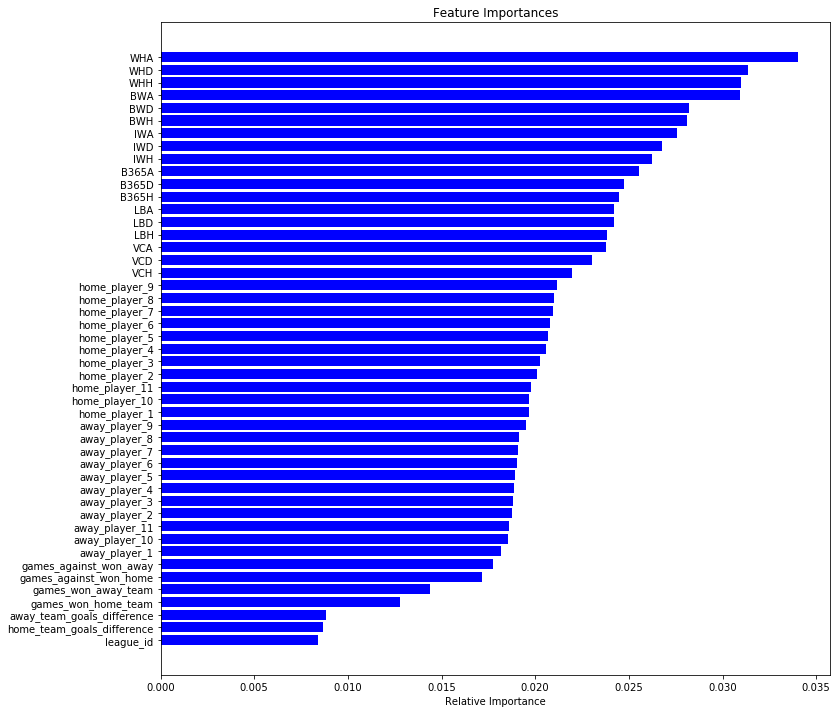

In [47]:
y,classified = random_forest_classifier(match_data_with_players)


In [48]:
betz = bet_decider(classified)


In [49]:
get_return_on_one_dollar(betz)


2.4582902330118821

<H2> Getting Current Data-The English Premier League </H2>

In [51]:
import datetime

In [52]:
def format_datetime_to_string(date):
            #converts a datetime to wanted string format 
            #converts the date year to a str 
            date_year = str(date.year)
            #gets day and month from the date 
            date_month = date.month
            date_day = date.day
            #if the day is less then 10 then string and add 0 else just str 
            if date_day<10:
                date_day = '0'+str(date_day)
            else:
                date_day= str(date_day)
            #if the month is less then 10 then string and add 0 else just str 
            if date_month <10:
                date_month = '0'+str(date_month)
            else:
                date_month = str(date_month)
            #create str
            date = date_year+date_month+date_day
            return date

In [53]:
def get_good_date(date,first_date = True):
    #gets the next date where games were played if 
    import datetime
    import requests
    from bs4 import BeautifulSoup
    #gets the most recent date 
    def get_initial_input_date():
        today = datetime.datetime.today()
        input_date = format_datetime_to_string(today)
        return input_date

    #checks whether the date given has games played on it 
    def is_good_date(date):
        #url format 
        url = 'http://www.espn.com/soccer/fixtures/_/date/'+date+'/league/eng.1'

        #try to request if link does not work then the date is bad 
        try:
            response = requests.get(url)

        except:
            print(date+" This date did not work")
        
            return False
            
        #find the first date of games which is the most recent on the page and if the page does not have     
        results_page = BeautifulSoup(response.content,'lxml')
        page_date  = results_page.find('h2',{'class':'table-caption'})
        if page_date is None: 
            return False 
        #gets the text of date 
        page_date = page_date.get_text()
        #Eliminates the day of week 
        date_loc = page_date.find(' ')
        page_date = page_date[(date_loc+1):]
        
        #gets the year and converts to string 
        year = str(pd.to_datetime(date).year)
        
        #Create the string and check if the date is before the given date if not then this is a good date 
        page_date = page_date+ ' ' + year
        page_date = pd.to_datetime(page_date)
        if page_date > pd.to_datetime(date):
            return False
        else:
            return True

    #get first date if needed     
    if first_date == True:
        date = get_initial_input_date()
        
    #otherwise get the next date 
    else:
        date = (pd.to_datetime(date))- datetime.timedelta(days=1)
        date = format_datetime_to_string(date)
        
        
    good_date = False
    
    #once one of the dates is treu then return it 
    while good_date == False:
        good_date = is_good_date(date)
        if good_date == False:
            date = (pd.to_datetime(date))- datetime.timedelta(days=1)
            date = format_datetime_to_string(date)
            

    
    return date


In [54]:
def get_links(end_date):
    #Gets all the links for espn before a certain date 
    end_date = pd.to_datetime(end_date)


    list_of_dates =[]
    list_of_urls = []
    #add date and link to the list 
    date = get_good_date(end_date)
    list_of_dates.append(date)
    contin = True


    #if the first date is before the end date then dont get another 
    if pd.to_datetime(list_of_dates[-1])<end_date:
        contin = False
    
    
    
    #while the date is still after the end date get the link and date and add to list 
    while contin==True:
        date = get_good_date(date,False)
        list_of_dates.append(date)
        
        #if the last date is before the end date remove it 
        if pd.to_datetime(list_of_dates[-1])<end_date:

            list_of_dates= list_of_dates[:-1]
            contin = False
            
    today = datetime.datetime.today()
    today = format_datetime_to_string(today)
    
    if list_of_dates[0] == today:
        list_of_dates = list_of_dates[1:]
    
    for date in list_of_dates:
        url = 'http://www.espn.com/soccer/fixtures/_/date/'+date+'/league/eng.1'
        list_of_urls.append(url)

        
        
    return (list_of_dates,list_of_urls)


In [55]:
def get_teams_score(match,date):
    #Gets the teams and the score for an entry from table given from espn
    
    #gets the string that contatins the home team and the score 
    home_and_score = match.match
    
    #reverses the string since the score is at the end 
    reversed_home_and_score = home_and_score[::-1]
    #index where the score is 
    score_index = 0 
    #For all chars in str
    for i in range(len(reversed_home_and_score)):
        #if letter Capital means that is the end of the score-set index 
        if (ord(reversed_home_and_score[i]) >= ord('A') and ord(reversed_home_and_score[i]) <= ord('Z')) :
                score_index = i
                break
    #Gets score 
    score = reversed_home_and_score[0:score_index]
    #score broken up to home and away 
    break_score = score.find('-')
    #get rid of spaces and get home and away score 
    home_score = score[(break_score+1):]
    home_score = home_score.replace(" ", "")
    away_score = score[0:break_score]
    away_score = away_score.replace(" ", "")
    
    home_team_index = len(home_and_score)-1
    #for all chars see if capital letters if so then get end of home_team through index else go to next letter
    for j in range(len(home_and_score)):
        if (ord(home_and_score[home_team_index])>= ord('A') and ord(home_and_score[home_team_index])<= ord('Z')):
            home_team_index = home_team_index - 3
            break
        else:
            home_team_index = home_team_index-1
    #home_team
    home_team = home_and_score[0:home_team_index]

    #away team str 
    away_team_code = match['Unnamed: 1']
    #same logic as for home 
    away_team_index = len(away_team_code)-1
    for k in range(len(away_team_code)):
        if (ord(away_team_code[away_team_index])>= ord('A') and ord(away_team_code[away_team_index])<=ord('Z')):
            away_team_index = away_team_index -3
            break
        else:
            away_team_index = away_team_index - 1
    away_team = away_team_code[0:away_team_index]
    
    #create series with teams, date, and score 
    match_info = pd.Series()
    match_info.loc['home_team'] = home_team
    match_info.loc['away_team'] = away_team
    
    match_info.loc['date'] =date
    match_info.loc['home_goals'] = home_score 
    match_info.loc['away_goals'] = away_score
    
    return match_info
    


In [56]:
def get_all_tables(links,dates):
    #for all links given with list of dates returns a dataframe of all the games scores and dates
    all_tables = pd.DataFrame(columns = ["home_team","away_team","home_goals","away_goals"])
    for i in range(len(links)):
        #get table for the link
        table = pd.read_html(links[i])
        tab = table[0]
        #call above function 
        table_data = tab.apply(lambda x: get_teams_score(x,dates[i]),axis = 1)
        all_tables = all_tables.append(table_data, ignore_index=True)
        
    return all_tables



    


In [57]:
def update_matches(last_date):
    #given a date will get all the games played  and score after that date
    
    dates,urls = get_links(last_date)
    table = get_all_tables(urls,dates)
    table['date'] = pd.to_datetime(table['date'])


    
    return table

In [58]:
def update_odds():
    #gets most recent odds through csv download from website 
    import csv
    import urllib
    import pandas as pd
    import time
    from time import mktime
    from datetime import datetime

    url1 = 'http://www.football-data.co.uk/mmz4281/1617/E0.csv'

    response1 = urllib.request.urlopen(url1)
    html1 = response1.read()

    with open('output1.csv', 'wb') as a:
        a.write(html1)

    EPL_New_1 = pd.read_csv('output1.csv')

    url2 = 'http://www.football-data.co.uk/mmz4281/1718/E0.csv'

    response2 = urllib.request.urlopen(url2)
    html2 = response2.read()

    with open('output2.csv', 'wb') as b:
        b.write(html2)

    EPL_New_2 = pd.read_csv('output2.csv')

    EPL_New = EPL_New_1.append(EPL_New_2)
    def get_good_time(date):
        date = time.strptime(date,'%d/%m/%y')
        date = datetime.fromtimestamp(mktime(date))
        return date

    EPL_New['Date'] =EPL_New.apply(lambda x: get_good_time(x['Date']),axis = 1)
    EPL_New_New = EPL_New[['Date','HomeTeam','AwayTeam','B365H','B365D','B365A','BWH','BWD','BWA','IWH','IWD','IWA','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','VCH','VCD','VCA']].copy()
    return EPL_New_New

In [59]:

def get_team(target,teams_list):
        #matches the team given to a list of teams-note teams may have different names in odds update and espn thus need for function 
        target_split  = target.split(' ')
        #for every team in the list see if the words in the team given are in the team from list 
        for team in teams_list:
            i  = 0 
            for word in target_split:
                if word in team: 
                    #if match with given team then add one
                    i+= 1 
            #if all the words match then this is the team 
            if i == len(target_split):
                target = team 
                return target
            


def get_correct_team_name_home(team,teams_list):
    #calls function for home_team
    home_team = get_team(team,teams_list)


    return home_team


def get_correct_team_name_away(team,teams_list):
    #calls function above for away 
    away_team = get_team(team,teams_list)


    return away_team
        
                    
    
        
                    
    

In [60]:

def get_key_betting(match):
    #creates a key for the updated odds data to match with the ESPN data for a given game
    home =match.HomeTeam
    away = match.AwayTeam
    date = match.Date
    date = str(date)
    key = home+away+date
    return key

def get_key_match(match):
    #creates a key for the ESPN data to match with odds for a given game 
    home =match.home_team
    away = match.away_team
    date = match.date
    date = str(date)
    key = home+away+date
    return key

    

In [61]:
def get_team_id(target,teams):
        #finds the id in the greater data set for a given team or creates a new one if it does not exsist
        teams_list = teams.team_long_name.unique() 
        target_split  = target.split(' ')
        for team in teams_list:
            i  = 0 
            for word in target_split:
                if word in team: 
                    i+= 1 
            #if all words in the target then this is correct get the id     
            if i == len(team.split(' ')):
                teams = teams[teams.team_long_name == team]
                id = teams.iloc[0].team_api_id
                return id
        #if no matches then create id using ASCII 
        s = target
        l = [ord(c) for c in s]
        x = 0 
        for value in l:
            x = x+value
                        

        x = x+1000000
        return x
                
            


def get_correct_team_id_home(team,teams):
    #calls above function for home team 
    
    home_team = get_team_id(team,teams)


    return home_team


def get_correct_team_id_away(team,teams):
    #calls function above for away team 
    away_team = get_team_id(team,teams)


    return away_team


In [62]:
def get_match_id(match):
    #creates a match id for a match using ascii of home away and date
    home =match.home_team
    away = match.away_team
    date = match.date
    date = str(date)
    key = home+away+date
    
    l = [ord(c) for c in key]
    x = 0 
    for value in l:
        x = x+value
                        

    x = x+1000000
    return x
                


In [63]:
def update():
    #using above functions updates the data to most recent data available 
    
    #Gets only the EPL teams and the last match from the EPL 
    EPL = good_matches[good_matches['league_id']==1729]
    last_date = EPL.sort_values(by = 'date', ascending = False).iloc[0].date
    #Get ESPN data 
    updated = update_matches(last_date)
    #Gets list of EPL teams 
    list_of_teams = EPL.home_team_api_id.unique()
    EPL_teams = teams.loc[teams.team_api_id.isin(list_of_teams)]
    #gets updated betting odds
    EPL_New_New = update_odds()
    #gets list of teams in ESPN data and fixes names for the Odds data 
    teams_list = updated.home_team.unique()
    EPL_New_New['HomeTeam'] = EPL_New_New.apply(lambda x:get_correct_team_name_home(x['HomeTeam'],teams_list),axis = 1)
    EPL_New_New['AwayTeam'] = EPL_New_New.apply(lambda x:get_correct_team_name_away(x['AwayTeam'],teams_list),axis = 1)
    #creates key for both dfs and makes the key the index
    EPL_New_New['key']= EPL_New_New.apply(get_key_betting,axis = 1)
    updated['key'] = updated.apply(get_key_match,axis =1)
    updated.set_index('key',drop = True,inplace = True)
    EPL_New_New.set_index('key',drop = True,inplace = True)
    #joins to data sets inner 
    updated_data = updated.join(EPL_New_New,how = "inner")
    #drops not needed tables 
    updated_data.drop(['PSH','PSA','PSD','HomeTeam','AwayTeam','Date'],axis = 1,inplace=True)
    #gets ids for home and away teams
    updated_data['home_team_api_id'] = updated_data.apply(lambda x: get_correct_team_id_home(x['home_team'],EPL_teams),axis = 1)
    updated_data['away_team_api_id'] = updated_data.apply(lambda x: get_correct_team_id_away(x['away_team'],EPL_teams),axis = 1)
    #Get id for match
    updated_data['match_api_id'] = updated_data.apply(get_match_id,axis = 1)
    #league id is EPL 
    updated_data['league_id'] = 1729
    #drops bad columns
    updated_data.drop(['away_team','home_team'],axis = 1,inplace = True)
    #converts goals to int
    def home_goals_to_int(row):
        goals = row.home_goals 
        goals = int(goals)
        return goals
    def away_goals_to_int(row):
        goals = row.away_goals 
        goals = int(goals)
        return goals
    updated_data['away_goals'] = updated_data.apply(away_goals_to_int,axis=1)
    updated_data['home_goals'] = updated_data.apply(home_goals_to_int,axis=1)

    #renames to match the bigger data sets
    updated_data =updated_data.rename(columns = {'away_goals':'away_team_goal','home_goals':'home_team_goal'})

    #add the data to the set of data 
    updated_data = pd.concat([good_matches,updated_data])
    updated_data.reset_index(inplace = True, drop = True)


    
    



    return updated_data


In [64]:
good_matches = update()
good_matches_to_date()

In [66]:
EPL = good_matches[good_matches['league_id']==1729]


In [67]:


odds, EPL_data = get_all_matches_data(EPL,players = False)


In [68]:
EPL_data

,match_api_id,league_id,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won_home,games_against_won_away,VCH,VCD,...,IWH,IWD,IWA,BWH,BWD,BWA,WHH,WHD,WHA,result
0,489042,1729,0,0,0,0,0,0,0.746606,0.173756,...,0.690419,0.203987,0.105594,0.698685,0.191219,0.110096,0.712871,0.198020,0.089109,D
1,489043,1729,0,0,0,0,0,0,0.766585,0.159705,...,0.746347,0.172234,0.081420,0.744148,0.165066,0.090786,0.763226,0.162359,0.074415,H
2,489044,1729,0,0,0,0,0,0,0.172989,0.250379,...,0.199482,0.256477,0.544041,0.182264,0.272036,0.545700,0.162078,0.270131,0.567791,A
3,489045,1729,0,0,0,0,0,0,0.505143,0.274220,...,0.495261,0.270142,0.234597,0.477612,0.283582,0.238806,0.485466,0.277626,0.236908,H
4,489046,1729,0,0,0,0,0,0,0.505143,0.274220,...,0.448217,0.280136,0.271647,0.464891,0.283293,0.251816,0.466725,0.278576,0.254699,H
5,489047,1729,0,0,0,0,0,0,0.468667,0.291141,...,0.448217,0.280136,0.271647,0.492191,0.280170,0.227638,0.457420,0.287732,0.254848,A
6,489048,1729,0,0,0,0,0,0,0.300077,0.282425,...,0.310132,0.281057,0.408811,0.323374,0.282953,0.393673,0.307211,0.278410,0.414378,H
7,489049,1729,0,0,0,0,0,0,0.518260,0.281994,...,0.513619,0.272374,0.214008,0.518664,0.275049,0.206287,0.492454,0.285941,0.221604,H
8,489050,1729,0,0,0,0,0,0,0.371295,0.283931,...,0.374101,0.280576,0.345324,0.370054,0.287820,0.342126,0.355080,0.306103,0.338817,H
9,489051,1729,0,0,0,0,0,0,0.721028,0.191793,...,0.690419,0.203987,0.105594,0.698685,0.191219,0.110096,0.683777,0.211645,0.104578,H


The score of the model is   0.471131639723
The best score from the GridSearch Randomforest is  0.550867052023
the best parameters from the gridsearch are:  {'max_depth': 8, 'n_estimators': 10, 'min_samples_leaf': 12, 'min_samples_split': 2}
The gridsearch optimized model score is  0.53233256351
The log loss for the no grid model is:  0.980254313786
The log loss for the grid search model is:  0.978684693713


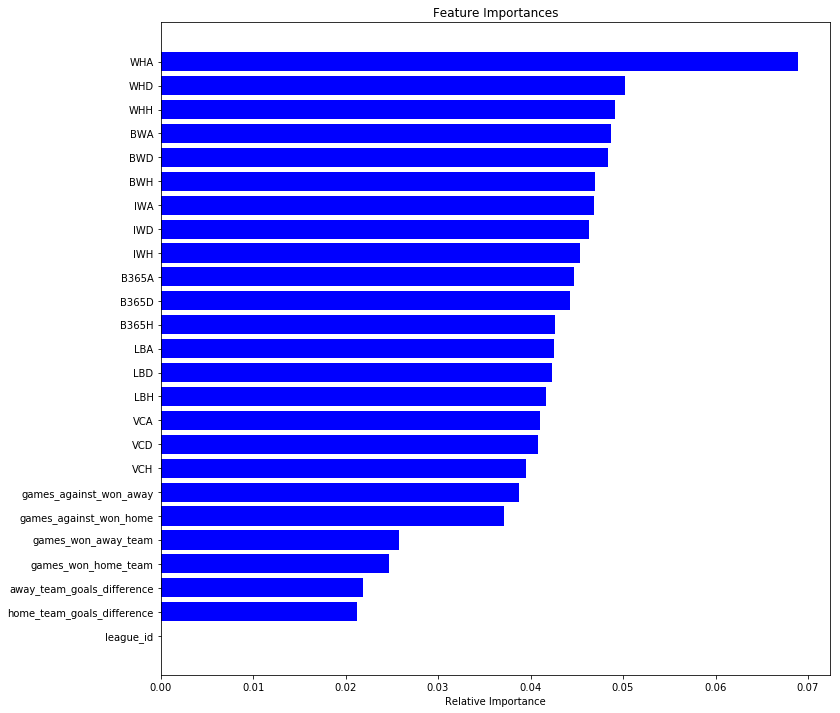

In [69]:
model,prob =  random_forest_classifier(EPL_data)



In [70]:
epl_bets = bet_decider(prob)
epl_bets



,A,D,H,B365H,B365A,B365D,BWH,BWA,BWD,IWH,...,result,best_home,best_away,best_draw,home_difference,away_difference,draw_difference,max_difference,bet,bet_odds
0,0.324139,0.207906,0.467955,0.454146,0.259166,0.286688,0.444694,0.265581,0.289725,0.430407,...,H,0.430407,0.259166,0.281466,0.037548,0.064973,-0.073560,0.064973,A,3.858531
1,0.184017,0.182510,0.633472,0.565763,0.171786,0.262451,0.550875,0.181789,0.267336,0.545657,...,D,0.532716,0.170508,0.262451,0.100756,0.013510,-0.079941,0.100756,H,1.877172
2,0.155552,0.184475,0.659973,0.548914,0.188827,0.262259,0.549814,0.190988,0.259198,0.513343,...,D,0.496894,0.188827,0.259198,0.163078,-0.033275,-0.074723,0.163078,H,2.012500
3,0.584733,0.162391,0.252877,0.161689,0.634073,0.204238,0.162261,0.630406,0.207333,0.131968,...,D,0.131968,0.612921,0.199281,0.120908,-0.028189,-0.036891,0.120908,H,7.577586
4,0.392200,0.248964,0.358837,0.288462,0.423077,0.288462,0.298097,0.413270,0.288633,0.298701,...,A,0.285714,0.395062,0.285714,0.073122,-0.002862,-0.036751,0.073122,H,3.500000
5,0.222174,0.239244,0.538582,0.539773,0.204545,0.255682,0.546763,0.201439,0.251799,0.555722,...,D,0.533708,0.188946,0.251279,0.004874,0.033229,-0.012035,0.033229,A,5.292528
6,0.568945,0.204199,0.226856,0.185160,0.571818,0.243022,0.172989,0.576631,0.250379,0.196998,...,A,0.172989,0.540338,0.238876,0.053867,0.028607,-0.034676,0.053867,H,5.780702
7,0.177107,0.425229,0.397664,0.540541,0.216216,0.243243,0.536284,0.216743,0.246973,0.500317,...,H,0.500317,0.209581,0.230769,-0.102653,-0.032474,0.194460,0.194460,D,4.333333
8,0.121928,0.340555,0.537517,0.473684,0.263158,0.263158,0.489796,0.244898,0.265306,0.479248,...,D,0.470149,0.244898,0.261528,0.067368,-0.122970,0.079027,0.079027,D,3.823684
9,0.598779,0.055925,0.345296,0.121930,0.672715,0.205355,0.135444,0.653866,0.210690,0.135444,...,H,0.120000,0.653866,0.202703,0.225296,-0.055087,-0.146777,0.225296,H,8.333333


In [71]:
get_return_on_one_dollar(epl_bets)

19.565518387564069

<h1>Should I bet an upcoming game?</h1>

In [73]:
def dynamic_predictor(game):
    #predicts outcame of game given a game info u

    dsf = model.predict_proba(game)

    probs = pd.DataFrame(dsf,columns = ["A","D","H"])
    return probs

In [74]:
def are_these_good_odds(home_id,away_id,date):
    #Given info on the team and a future date are odds offered good odds and should i bet 
    game = get_info(home_id,away_id,date)
    probs = dynamic_predictor(game)
    home_odds = input("Enter bookies home odds")
    away_odds = input("Enter bookies away odds")
    draw_odds = input("Enter bookies draw odds")
    home_odds = int(home_odds)
    away_odds = int(away_odds)
    draw_odds = int(draw_odds)

    home_prob  = 1/home_odds
    away_prob  = 1/away_odds
    draw_prob = 1/draw_odds
    total_prob = home_prob+away_prob+draw_prob
    home_prob = home_prob / total_prob
    draw_prob= draw_prob / total_prob
    away_prob = away_prob / total_prob
    if probs['A'].iloc[0]>away_prob:
        print("Away is good bet")
    if probs['D'].iloc[0]>draw_prob:
        print("Draw is good bet")
    if probs['H'].iloc[0]>home_prob:
        print("Home is good bet")
        
    
    

In [79]:
def get_info(home_id,away_id,date,matches=EPL):
    #Gets info needed to predict the game 
    #Get last n matches of home and away team
    matches_home_team = get_past_matches(matches,home_id,date,10)
    matches_away_team = get_past_matches(matches, away_id,date,10)
    
    

    
    
    #Get last n matches of both teams against each other
    last_matches_against = get_past_matches_against_team(matches, date, home_id, away_id)
    
    
    #get goals homea and away team scored in last n matches they played 
    home_goals = goals(matches_home_team, home_id)
    away_goals = goals(matches_away_team, away_id)
    



    #get goals homea and away team scored in last n matches they played against each other 
    home_goals_against = goals_against(matches_home_team, home_id)
    away_goals_against = goals_against(matches_away_team, away_id)



    #Create a series with the information from above 
    data = pd.Series()
    data.loc[ 'league_id'] = 1729
    data.loc['home_team_goals_difference'] = home_goals - home_goals_against
    data.loc['away_team_goals_difference'] = away_goals - away_goals_against
    data.loc['games_won_home_team'] = get_wins(matches_home_team, home_id) 
    data.loc['games_won_away_team'] = get_wins(matches_away_team, away_id)
    data.loc['games_against_won_home'] = get_wins(last_matches_against, home_id)
    data.loc['games_against_won_away'] = get_wins(last_matches_against, away_id)
    data.loc['BWH'] = input("Enter BW Home odds")
    data.loc['BWA'] = input("Enter BW Away odds")
    data.loc['BWD'] = input("Enter BW Draw odds")
    data.loc['IWH'] = input("Enter IW Home odds")
    data.loc['IWA'] = input("Enter IW Away odds")
    data.loc['IWD'] = input("Enter IW Draw odds")
    data.loc['LBH'] = input("Enter LB Home odds")
    data.loc['LBA'] = input("Enter LB Away odds")
    data.loc['LBD'] = input("Enter LB Draw odds")
    data.loc['B365H'] = input("Enter B365 Home odds")
    data.loc['B365A'] = input("Enter B365 Away odds")
    data.loc['B365D'] = input("Enter B365 Draw odds")
    data.loc['WHH'] = input("Enter WH Home odds")
    data.loc['WHA'] = input("Enter WH Away odds")
    data.loc['WHD'] = input("Enter WH Draw odds")
    data.loc['VCH'] = input("Enter VC Home odds")
    data.loc['VCA'] = input("Enter VC Away odds")
    data.loc['VCD'] = input("Enter VC Draw odds")
    data = data.values.reshape(1,-1) 
    
    return data


In [81]:
are_these_good_odds(10260,9825,'12/25/17')

Enter BW Home odds3
Enter BW Away odds4
Enter BW Draw odds4
Enter IW Home odds4
Enter IW Away odds4
Enter IW Draw odds4
Enter LB Home odds4
Enter LB Away odds4
Enter LB Draw odds4
Enter B365 Home odds4
Enter B365 Away odds4
Enter B365 Draw odds4
Enter WH Home odds4
Enter WH Away odds4
Enter WH Draw odds4
Enter VC Home odds4
Enter VC Away odds4
Enter VC Draw odds4
Enter bookies home odds4
Enter bookies away odds4
Enter bookies draw odds4
Home is good bet


#### 